## Info

In [46]:
# Martingale Betting: Bet the moneyline on a team. If they lose, double the same bet for the same team in their next game.

# The purpose of this notebook is first wave of experiments with Martingale betting system.

# Data sources

# 2021
# https://www.baseball-reference.com/teams/DET/2021-schedule-scores.shtml
# https://www.covers.com/sport/baseball/mlb/teams/main/detroit-tigers

# 2019
# https://www.baseball-reference.com/teams/DET/2019-schedule-scores.shtml
# https://www.covers.com/sport/baseball/mlb/teams/main/detroit-tigers/2019

# 2018
# same as above

# note: Covers Line: an average comprised of odds from multiple sportsbooks
# from https://www.covers.com/mlb/dodgers-vs-braves-picks-predictions-october-23-2021

# terminology
# team-season: a specific season for a specific team
# refill factor: the number of games you're guaranteed until another refill
# dataset name: a 5 letter string of the 3-letter team abbreviation (on baseball-reference) + last 2 digits of season year

## Import Packages

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from scipy.interpolate import UnivariateSpline
import matplotlib as mpl
import statistics
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## Functions

In [67]:
# functions to help process one column of data
def res(s):
    return s[0]
def line(s):
    return s[2:]

def process_data(fname): 
    """
    Processes an individual file into a pandas Dataframe
  
    Parameters:
    fname (str): file name
  
    Returns:
    df (pd.DataFrame): processed team-season data
    """
    df = pd.read_csv(join("data", fname), encoding= 'unicode_escape')
    df['result'] = df['result and moneyline'].apply(res)
    df['line'] = df['result and moneyline'].apply(line).apply(int)
    df.drop('result and moneyline', 1, inplace = True)
    df.sort_values(by=['game'], inplace=True)
    return df

def sim_szn(ds_name, base_bet, start_balance, r):
    """
    Carries out a season of Martingale betting using the data for an individual team-season
  
    Parameters:
    ds_name (str): dataset name
    base_bet (int): base bet amount
    start_balance (int): balance at beginning of season
    r (int): refill factor
  
    Returns:
    df (pd.DataFrame): full team-season bet data
    """
    df = process_data(ds_name)
    curr_bet = base_bet
    balance = start_balance
    earnings = 0
    bet_hist = []
    payout_hist = []
    balance_hist = []
    earnings_hist = []

    for index, row in df.iterrows():
        payout = 0
        if curr_bet > balance: #  losing streak has overwhelmed balance
            curr_bet = base_bet # reset current bet
            if curr_bet > balance: # refill account
                earnings -= ((2**r - 1) * base_bet - balance)
                balance = (2**r - 1) * base_bet * 7
        bet_hist.append(curr_bet)
        if row['result'] == 'W': # team wins
            if (row['line'] > 0): # underdog
                payout = round(0.01 * row['line'] * curr_bet, 2)
            else: # favorite
                payout = round(-100 / row['line'] * curr_bet, 2)
            curr_bet = base_bet # reset
        else: # team loses
            payout = curr_bet * -1
            curr_bet = curr_bet * 2 # double down
        balance += payout
        earnings += payout
        payout_hist.append(payout)
        balance_hist.append(balance)
        earnings_hist.append(earnings)
    
    df['bet'] = bet_hist
    df['payout'] = payout_hist
    df['balance'] = balance_hist
    df['earnings'] = earnings_hist
    
    return df

def full_run(ds_names, base_bet=4, start_balance=50, r=2):
    """
    Carries out season for all teams listed in ds_names parameter
    note: parameter defaults are arbitrary
  
    Parameters:
    ds_names (list of str's): list of dataset names
    base_bet (int): see sim_szn function
    start_balance (int): see sim_szn function
    r (int): see sim_szn function
  
    Returns:
    bet_data (dict): maps dataset names to each team-season's data
    team_data (pd.DataFrame): contains aggregate data for each team-season
    """
    datasets, wins, earnings = [],[],[]
    bet_data = {}
    for i in range(len(ds_names)):
        datasets.append(sim_szn(ds_names[i] + ".csv", base_bet, start_balance, r))
        bet_data[ds_names[i]] = datasets[i]
    for df in bet_data:
        wins.append(bet_data[df]["result"].value_counts()["W"])
        earnings.append(bet_data[df].iloc[len(bet_data[df].index) - 1]['earnings'])
    team_data = pd.DataFrame({'Name':ds_names, 'Wins': wins, 'Earnings': earnings})
    team_data.sort_values(by=['Wins'], inplace=True)
    return bet_data, team_data

# helper function for plots
def league_color(ds_name):
    if ds_name in dsn_AL21:
        return "r"
    elif ds_name in dsn_NL21:
        return "b"
    elif ds_name in dsn_AL19:
        return "darkorange"
    elif ds_name in dsn_NL19:
        return "darkviolet"
    else:
        return "g"
    
# plot results
def plot_results(bet_data, team_data):
    mpl.rcParams["figure.figsize"] = [16,16]
    fig, (ax1, ax2) = plt.subplots(2)

    for df in bet_data:
        x = bet_data[df]['game']
        y = bet_data[df]['earnings']
        ax1.plot(x, y, lw = 2, label = df)

    ax1.grid(linestyle = '--', linewidth = 0.5)
    ax1.set_title("Cumulative Earnings vs. Game")
    ax1.set_xlabel("Game Number (Chronological)")
    ax1.set_ylabel("Cumulative Earnings")
    ax1.set_xlim(0, 163)

    ax2.grid(linestyle = '--', linewidth = 0.5)
    ax2.set_title("Cumulative Earnings vs. Wins")
    ax2.set_xlabel("Wins in Season")
    ax2.set_ylabel("Cumulative Earnings")
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='AL21', markerfacecolor='r', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='NL21', markerfacecolor='b', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='AL19', markerfacecolor='darkorange', markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='NL19', markerfacecolor='darkviolet', markersize=7)]
    ax2.legend(handles=legend_elements)
    ax2.scatter(team_data['Wins'], team_data['Earnings'], color = team_data['Name'].apply(league_color))
    
# grid search
def grid_search(min_wins, params):
    param_gs = pd.DataFrame({'base_bet': [], 'start_balance': [], 'refill': [], 'earn_avg': [], 'earn_sd': [],
                             'pct_pos': [], 'test_stat': []})
    for i in params['base_bet']: # base_bet
        for j in params['start_balance']: # starting_balance
            for k in params['refill']: # refill
                bet_data, team_data = full_run(ds_names, i, j, k)
                team_data_f = team_data[team_data['Wins'] >= min_wins]
                team_data_pos_earn = team_data_f[team_data_f['Earnings'] > 0]
                avg = round(statistics.mean(team_data_f['Earnings']), 2) # Avg Team Earnings
                sd = round(statistics.stdev(team_data_f['Earnings']), 2) # St. Dev Team Earnings
                p = round(100 * len(team_data_pos_earn) / len(team_data_f), 2) # Percent of teams with positive earnings
                z = round(avg/sd, 2)
                param_gs = param_gs.append({'base_bet': i, 'start_balance': j, 'refill': k, 'earn_avg': avg, 'earn_sd': sd,
                                'pct_pos': p, 'test_stat': z}, ignore_index = True)
    print('grid search complete')
    return param_gs

def param_boxplot(df, x, y):
    df.sort_values(by=[y], inplace=True)
    levels = df[x].unique()
    levels.sort()
    box_data = []
    for l in levels:
        box_data.append(df[df[x] == l][y])
    plt.boxplot(box_data)
    plt.xticks(list(range(len(levels)+1)[1:]), levels)
    plt.xlabel(x)
    plt.ylabel(y)

## Filenames

In [59]:
# derived from filenames in data directory
dsn_AL21 = ["det21", "chw21", "cle21", "kcr21", "min21", "tbr21", "bos21", "nyy21", "tor21", "bal21", "hou21", "sea21",
            "oak21", "laa21", "tex21"]
dsn_NL21 = ['atl21', 'phi21', 'nym21', 'mia21', 'was21', 'mil21', 'stl21', 'cin21', 'chc21', 'pit21', 'sfg21', 'lad21',
           'sdp21', 'col21', 'ari21']
dsn_AL19 = ['det19', "chw19", "cle19", "kcr19", "min19", "tbr19", "bos19", "nyy19", "tor19", "bal19", "hou19", "sea19",
            "oak19", "laa19", "tex19"]
dsn_NL19 = ['atl19', 'phi19', 'nym19', 'mia19', 'was19', 'mil19', 'stl19', 'cin19', 'chc19', 'pit19', 'sfg19', 'lad19',
            'sdp19', 'col19', 'ari19']
ds_names = dsn_AL21 + dsn_NL21 + dsn_AL19 + dsn_NL19

## Analysis

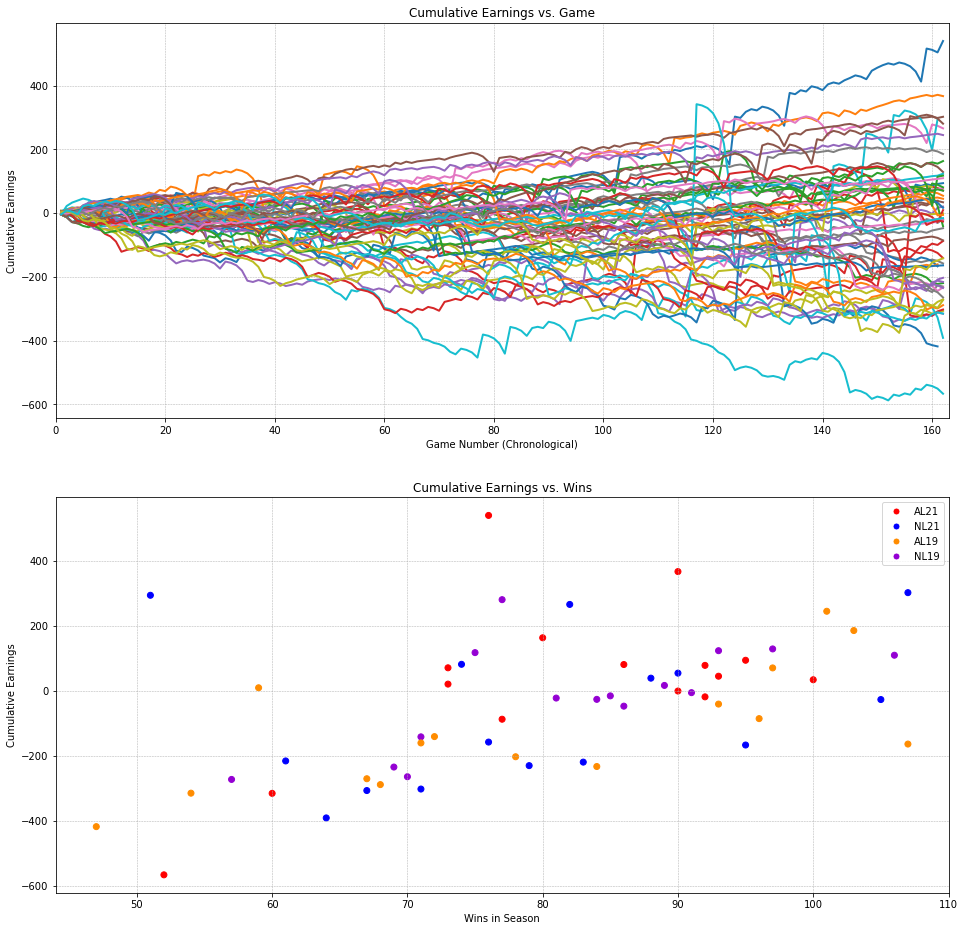

In [68]:
# run once with default parameters
bet_data, team_data = full_run(ds_names)

# plot results
plot_results(bet_data, team_data)

In [61]:
# grid search
params = {'base_bet': [2, 5, 10, 20],
          'start_balance': [25, 50, 100, 200, 1000],
          'refill': [1, 2, 3, 4, 5]
         }
param_gs = grid_search(73, params)

grid search complete


In [62]:
# quick analyze results of grid search
param_gs.sort_values(by=['earn_avg', 'test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))
param_gs.sort_values(by=['pct_pos', 'test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))
param_gs.sort_values(by=['test_stat'], inplace=True, ascending=False)
display(param_gs.head(5))

,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
96,20.0,1000.0,2.0,306.40,1079.74,59.52,0.28
97,20.0,1000.0,3.0,278.42,1126.17,59.52,0.25
98,20.0,1000.0,4.0,278.04,1134.03,61.90,0.25
95,20.0,1000.0,1.0,230.97,1136.46,57.14,0.20
80,20.0,50.0,1.0,184.37,766.86,50.00,0.24


,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
21,2.0,1000.0,2.0,70.46,265.57,88.1,0.27
20,2.0,1000.0,1.0,68.32,273.80,88.1,0.25
23,2.0,1000.0,4.0,68.27,273.96,88.1,0.25
22,2.0,1000.0,3.0,66.25,282.14,88.1,0.23
24,2.0,1000.0,5.0,64.48,289.62,88.1,0.22


,base_bet,start_balance,refill,earn_avg,earn_sd,pct_pos,test_stat
11,2.0,100.0,2.0,30.63,107.97,59.52,0.28
96,20.0,1000.0,2.0,306.40,1079.74,59.52,0.28
5,2.0,50.0,1.0,23.61,85.05,52.38,0.28
65,10.0,200.0,1.0,113.24,403.56,50.00,0.28
35,5.0,100.0,1.0,56.63,201.78,50.00,0.28


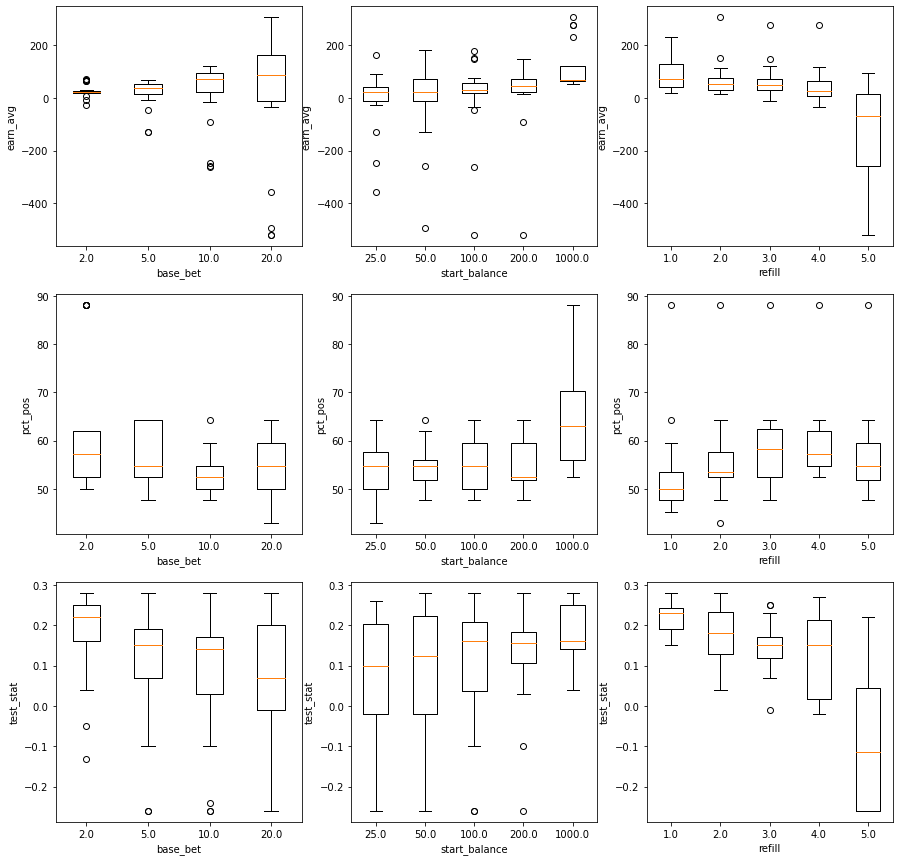

In [63]:
# analyze effect of parameters

mpl.rcParams["figure.figsize"] = [15,15]

plt.subplot(3,3,1)
param_boxplot(param_gs, 'base_bet', 'earn_avg')

plt.subplot(3,3,2)
param_boxplot(param_gs, 'start_balance', 'earn_avg')

plt.subplot(3,3,3)
param_boxplot(param_gs, 'refill', 'earn_avg')

plt.subplot(3,3,4)
param_boxplot(param_gs, 'base_bet', 'pct_pos')

plt.subplot(3,3,5)
param_boxplot(param_gs, 'start_balance', 'pct_pos')

plt.subplot(3,3,6)
param_boxplot(param_gs, 'refill', 'pct_pos')

plt.subplot(3,3,7)
param_boxplot(param_gs, 'base_bet', 'test_stat')

plt.subplot(3,3,8)
param_boxplot(param_gs, 'start_balance', 'test_stat')

plt.subplot(3,3,9)
param_boxplot(param_gs, 'refill', 'test_stat')

## TODO

* look into related work
* test on specific conference (interactions?)
* take some money out at a certain threshold? poker: cannot pocket fraction of your cash at cash games. only money you can pocket is when you leave table
* add data